[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/pycroscopy/blob/main/jupyter_notebooks/Image_Registration.ipynb)


# <center> A processing and analytics system for microscopy data workflows: the Pycroscopy ecosystem of packages

<center><font size = 3> R. Vasudevan<sup>1,*</sup>, S. M. Valleti,<sup>2</sup> M. Ziatdinov,<sup>1,3</sup> G. Duscher,<sup>4,**</sup> and S. Somnath<sup>5,6</sup> </font></center>

<sup>1</sup>Center for Nanophase Materials Sciences, Oak Ridge National Laboratory \
<sup>2</sup>Bredesen Center for Interdisciplinary Research, University of Tennessee, Knoxville \
<sup>3</sup>Computational Sciences and Engineering Division, Oak Ridge National Laboratory \
<sup>4</sup>Department of Materials Science and Engineering, University of Tennessee, Knoxville \
<sup>5</sup>National Center for Computational Sciences, Oak Ridge National Laboratory \
<sup>6</sup>Current affiliation: McKinsey Consulting Group

# Registration of a Stack of Images
by Gerd Duscher, 2023

Microscopy Facilities
Joint Institute of Advanced Materials
The University of Tennessee, Knoxville
    
Model based analysis and quantification of data acquired with transmission electron microscopes
We us this notebook **only** for a stack of images from a reference crystal.
    
<b> This notebook will not work in Google Colab </b>


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](1_Correcting_Image_Distortions.ipynb), please install [pyTEMlib](https://github.com/gduscher/pyTEMlib) with the code cell below.

### Install missing packages
This can take a while for the first time. This code will have to run at least once on you computer. Make sure to restart the kernel so that you are then using the latest version.

In [ ]:
# pyTEMlib and other requried packages setup 
!pip install -U pyTEMlib pycroscopy wget pyqt5

print('done')

In [1]:
#download the data file from zenodo
import wget
wget.download(url='https://zenodo.org/record/8190744/files/STO-stack.h5?download=1',
              out = 'STO-stack.h5')

'STO-stack.h5'

## Import the usual libraries


You'll need at least pyTEMlib version 0.2023.8.0

You can load that library with the code cell above:

In [2]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

# Import libraries from pycroscopy

import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.probe_tools
import pyTEMlib.atom_tools

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'Image_Registration'
__notebook_version__ = '2023_08_08'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2023.8.0


## Load an image stack :

Please, load an image stack. <br> 

You may use 'STO-stack.h5' to test this notebook.

A stack of images is used to reduce noise, but for an added image the images have to be aligned to compensate for drift and other microscope instabilities.

You select here (with the ``Open_Nion_Directory`` parameter,) whether an **open file dialog** apears in the code cell below the next one or whether you want to get a list of files (Nion has a weird way of dealing with file names).
Note that the **open file dialog** might not apear in the foreground!

In [3]:
datasets = ft.open_file()
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)',), value='Chann…

<IPython.core.display.Javascript object>


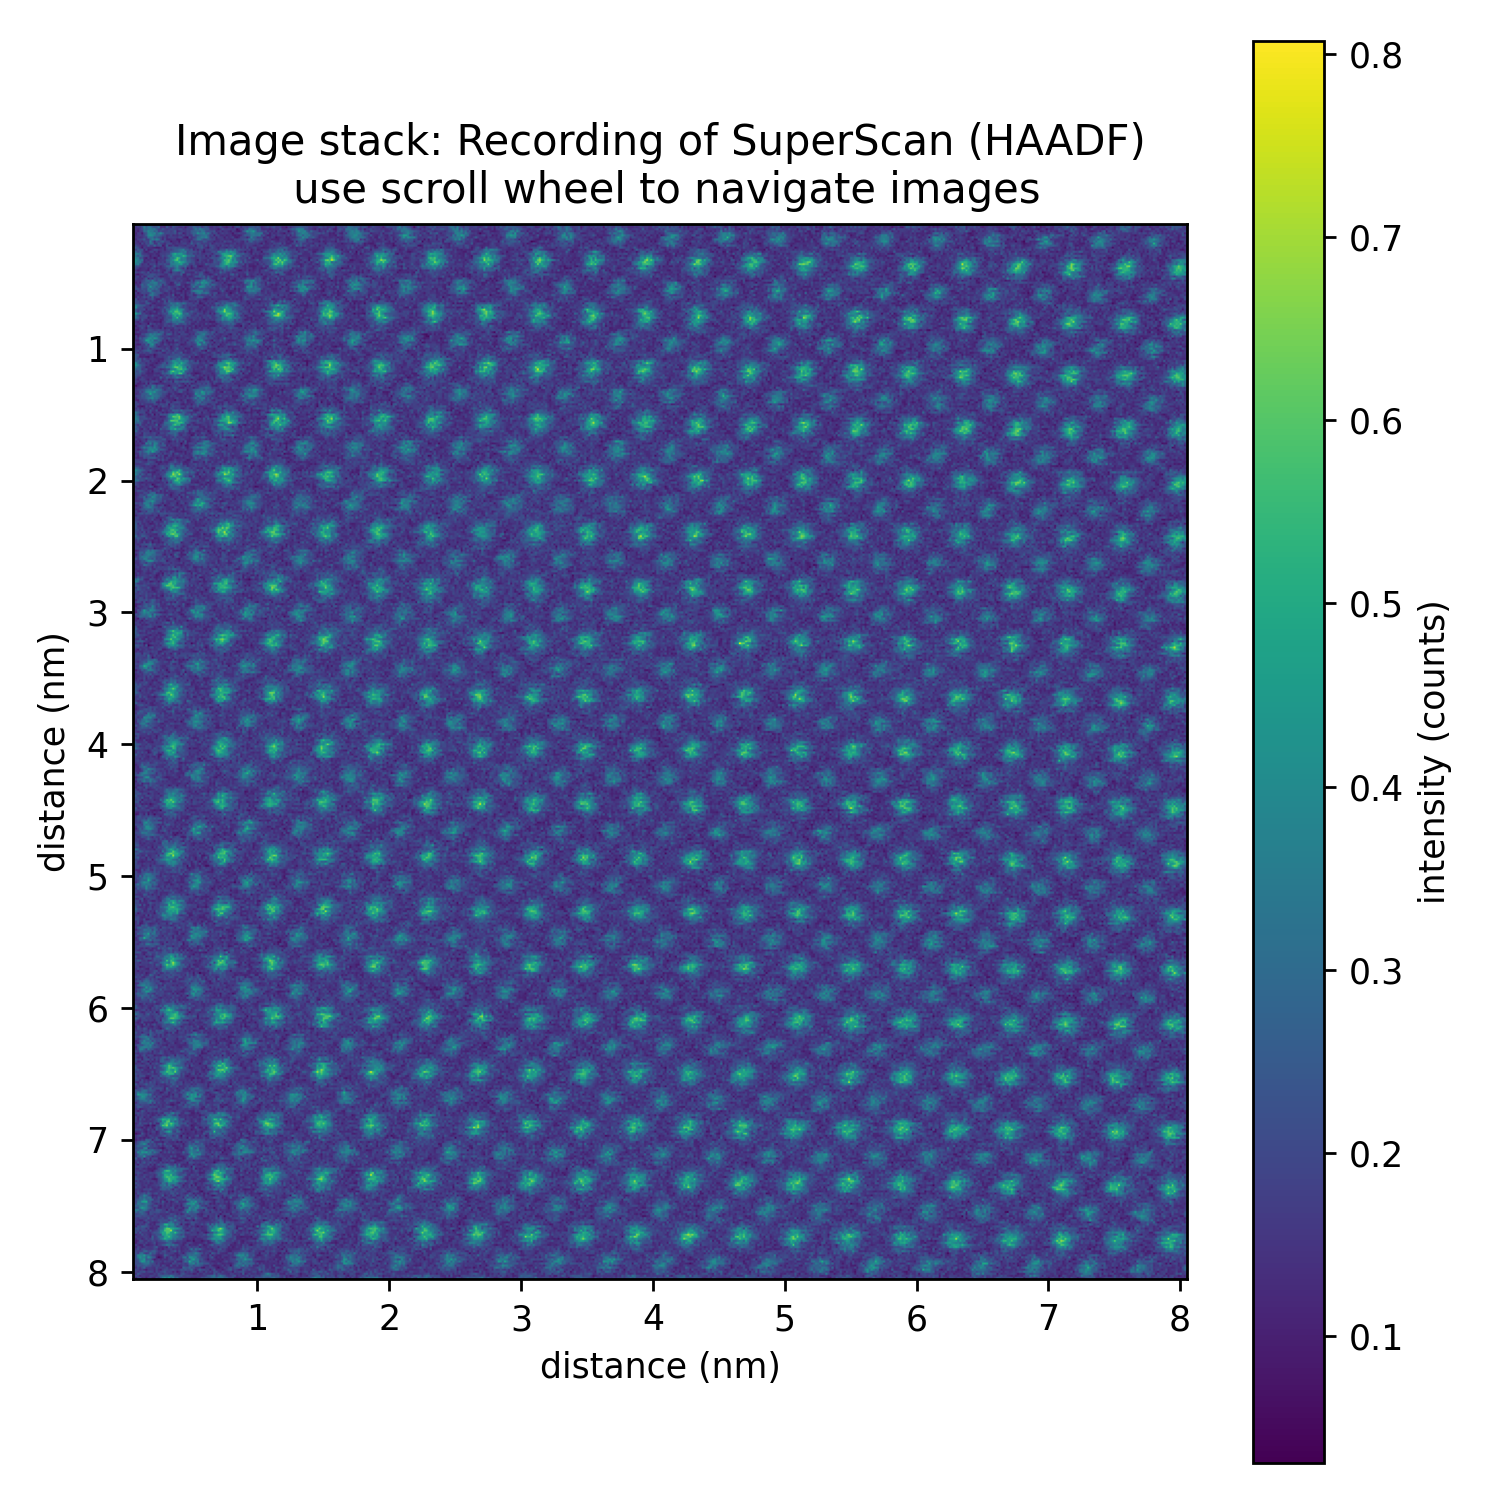

In [13]:
dataset = chooser.dataset
view = dataset.plot(figsize = (6, 6))

In [14]:
view.savefig('Fig5a.png', dpi = 300)

Some of the metadata is available in the ``hdf5_dataset`` but all ``original metadata`` can be found in the ``Channel_000`` of this hyrachical data format.

## Complete Registration 

Takes a while, depending on your computer between 1 and 10 minutes

### Rigid Registration

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

### Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

Stack contains  25  images, each with 512  pixels in x-direction and  512  pixels in y-direction


100%|██████████| 25/25 [00:07<00:00,  3.54it/s]


<IPython.core.display.Javascript object>


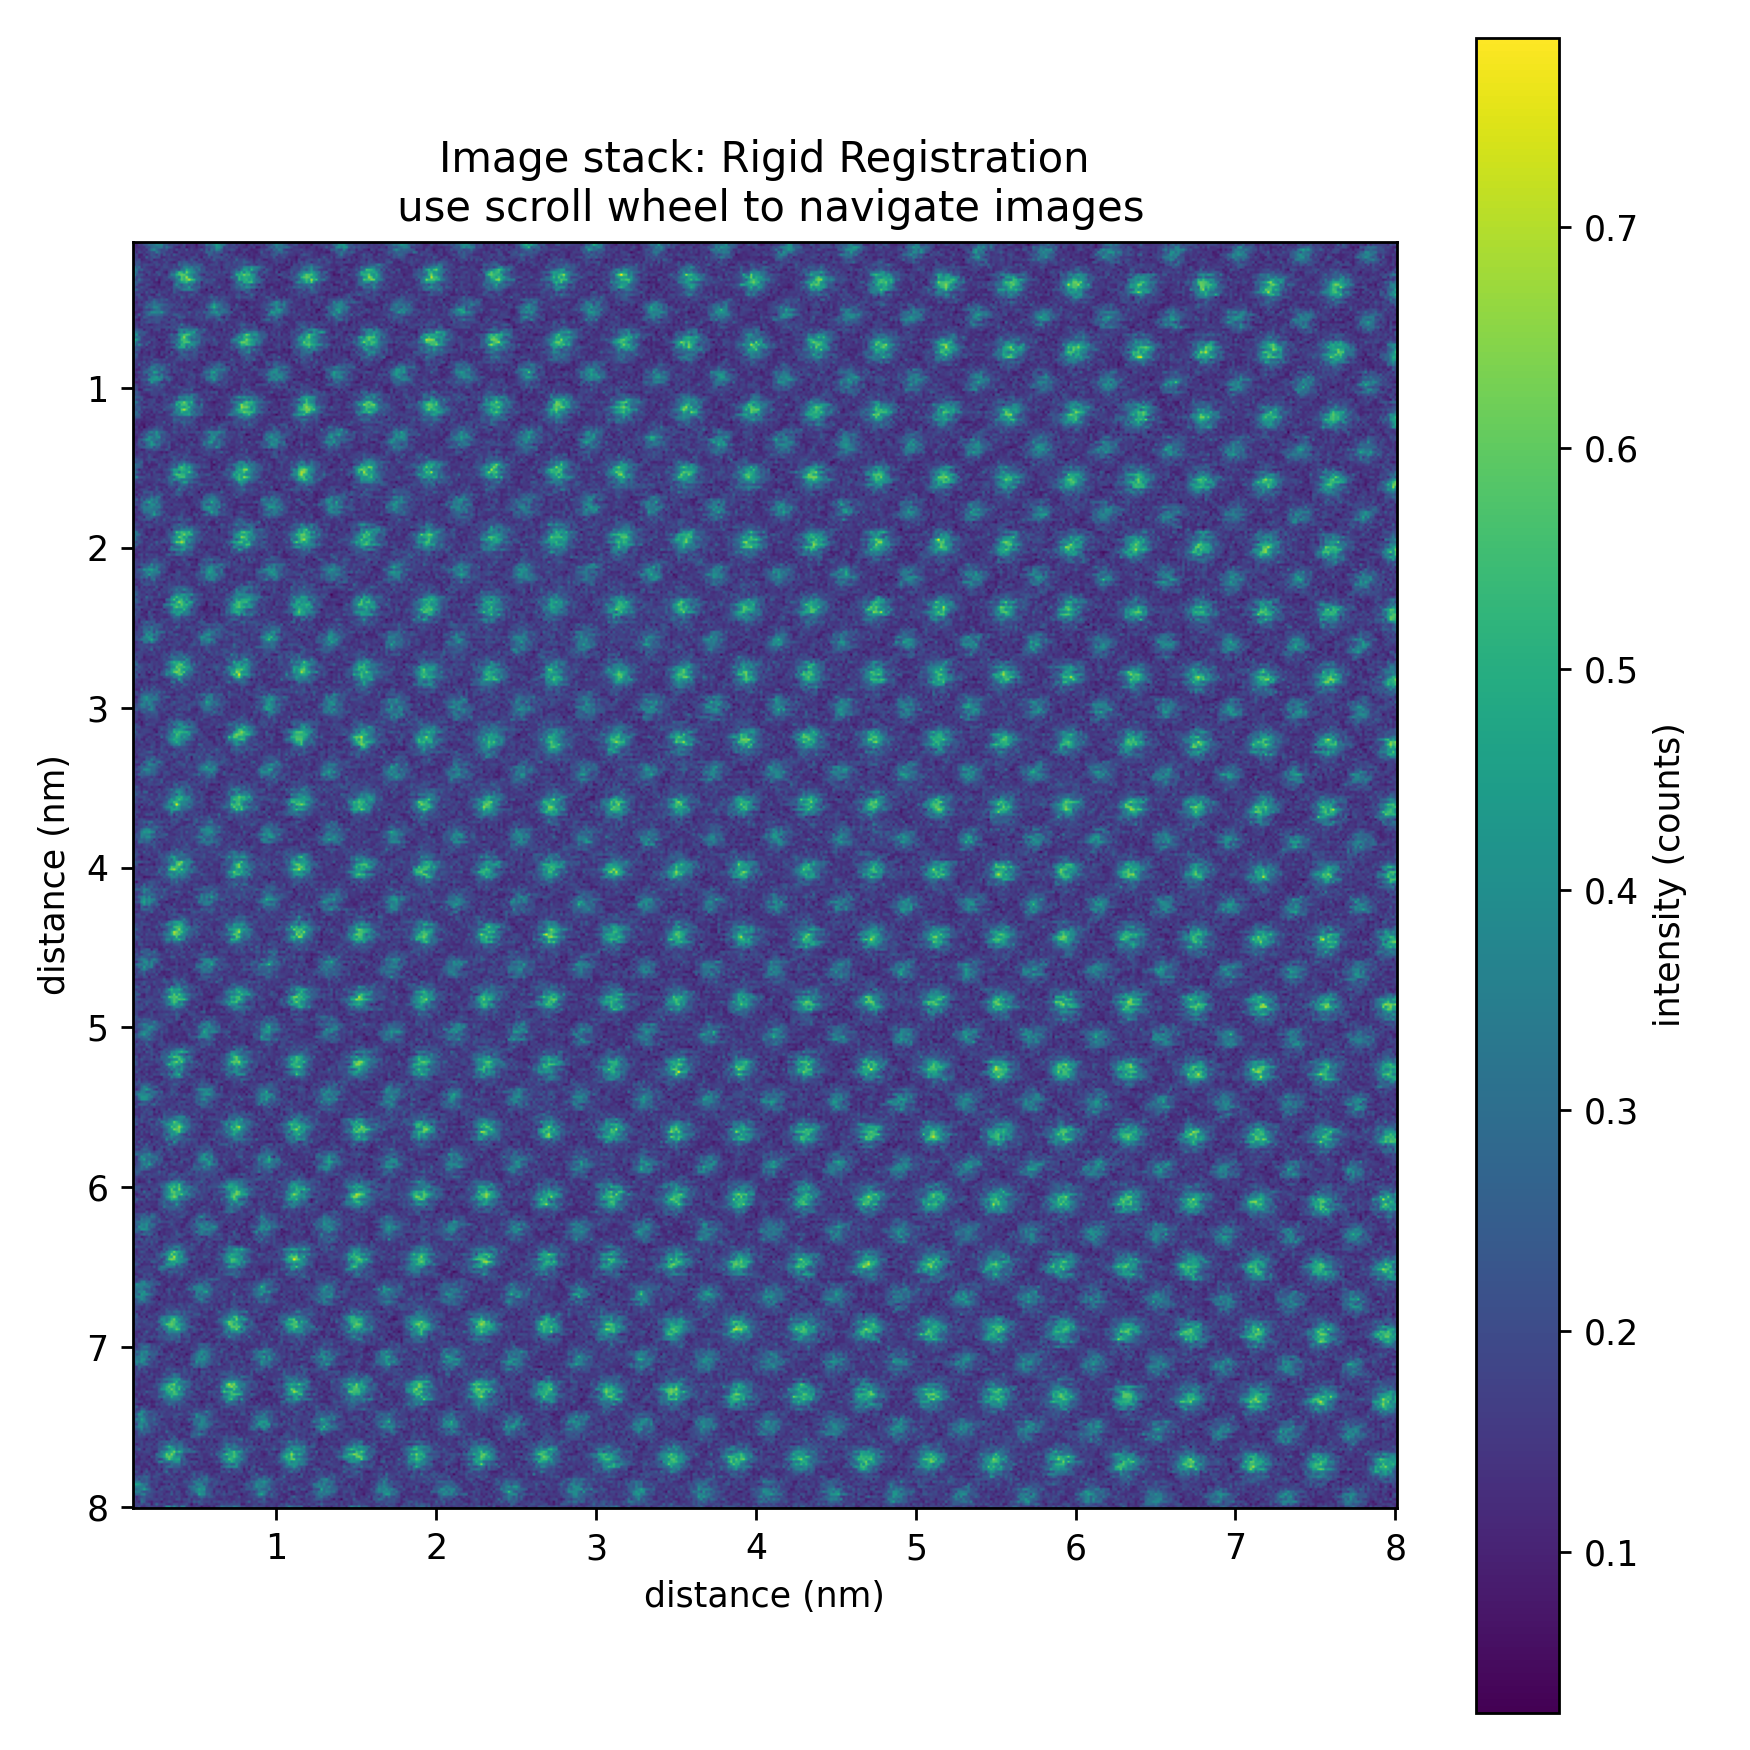

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(25, 506, 507), dtype=float64, chunksize=(25, 506, 507), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
frame:  stack (frame) of size (25,)
y:  distance (nm) of size (506,)
x:  distance (nm) of size (507,)
 with metadata: ['analysis', 'drift', 'input_crop', 'input_shape']

In [8]:
from pycroscopy.image.image_registration import rigid_registration, demon_registration

rig_reg_dataset = rigid_registration(dataset)

view = rig_reg_dataset.plot(figsize = (7,7))
rig_reg_dataset

### Check Drift

<IPython.core.display.Javascript object>


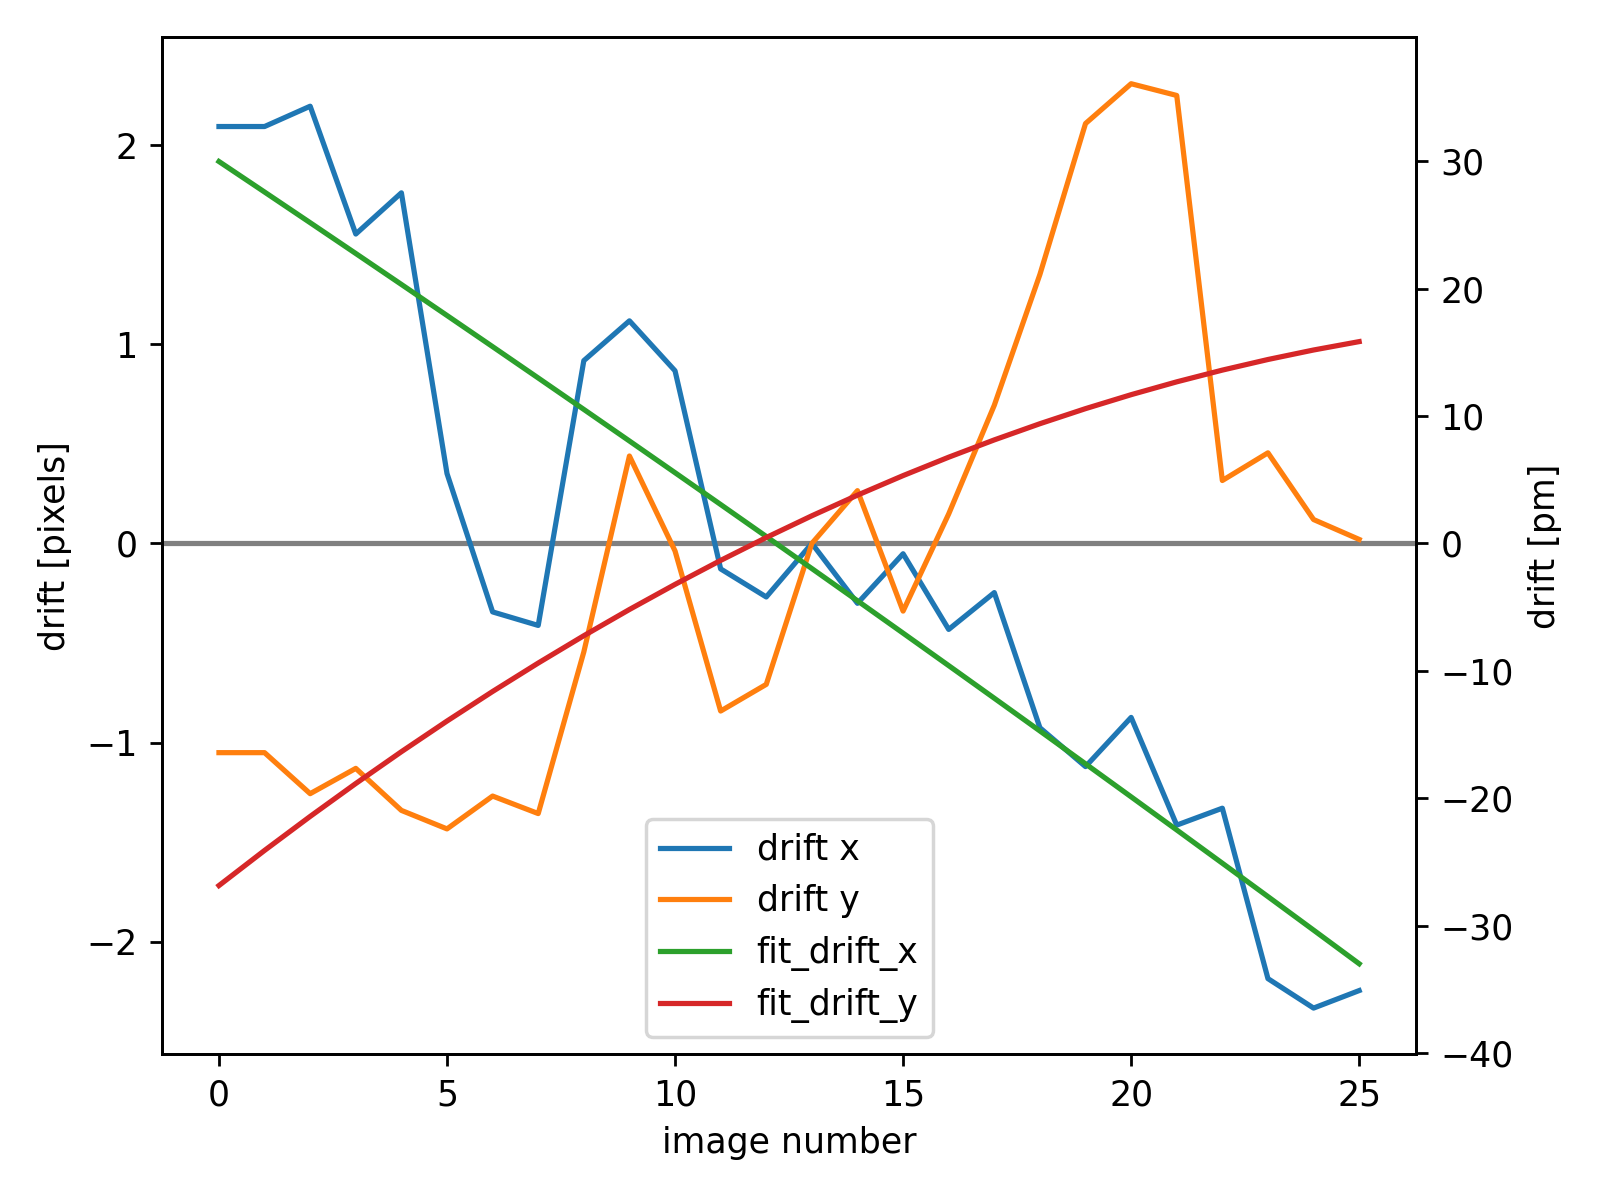

In [7]:
scale_x = ft.get_slope(rig_reg_dataset.x.values)*1000.
drift = rig_reg_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

plt.savefig('Fig5b.png', dpi = 300)

## Non-Rigid Registration

100%|██████████| 25/25 [10:17<00:00, 24.71s/it]

:-)
You have successfully completed Diffeomorphic Demons Registration


<IPython.core.display.Javascript object>


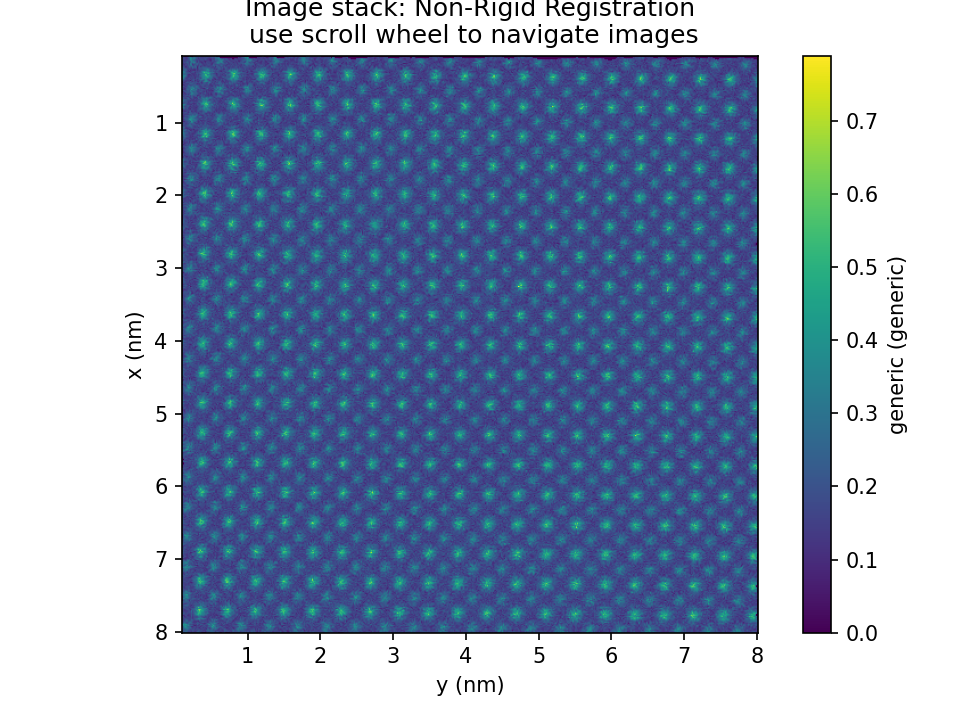

In [16]:
non_rigid_registered = demon_registration(rig_reg_dataset)

view = non_rigid_registered.plot()

## Appendix

### Demon Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

This Non-Rigid Registration consists of the following steps:

- determine ``reference`` image
    - For this we use the average of the rigid registered stack
    - this averaged stack is then smeared with a Gaussian of sigma 2 pixel to reduce noise
    - under the assumption that high frequency scan distortions cancel out over several images, we, therefore, obtained the center of mass of the atoms. 

- perform the ``demon registration`` filter to determine a distortion matrix
    - each single image of a stack is first smeared with a Gaussian of sigma of 2pixels
    - then the deformation matrix is determined for these images
    - the deformation matrix is a matrix where each pixel has a vector ( x, and y value) for the relative shift of this pixel.
    
- This deformation matrix is used to ``transform`` the image
	- The transformation is performed on the original image.
	- Important, here, is to set the interpolator method, (the image needs to be interpolated because the new pixels are not on an integer grid.)
    
    
Let's see what the different interpolators do.

|Method	| RMS contrast |	Standard |	Mean |
|-------|:--------------|:-------------|:-------|
|original   |0.1965806	|0.07764114	|0.3949583
|Linear	    |0.20159315	|0.079470366	|0.39421165
|BSpline	|0.20162606	|0.0794831 	|0.39421043
|Gaussian	|0.14310582	|0.056414302 	|0.39421389
|Hamming	|0.20163293	|0.07948672 	|0.39421496

The Gaussian interpolator as the only one seems to smear the signal.

We will use the ``Bspline`` method a fast and simple method that does not introduce spurious features and does not smear the signal.


#### Full Code of Demon registration 

In [18]:
import simpleITK as sitk

def DemonReg(cube, verbose = False):
    """
    Diffeomorphic Demon Non-Rigid Registration 
    Usage:
    ------
    DemReg = DemonReg(cube, verbose = False)

    Input:
        cube: stack of image after rigid registration and cropping
    Output:
        DemReg: stack of images with non-rigid registration

    Dempends on:
        simpleITK and numpy
    
    Please Cite: http://www.simpleitk.org/SimpleITK/project/parti.html
    and T. Vercauteren, X. Pennec, A. Perchant and N. Ayache
    Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy
    The Insight Journal, http://hdl.handle.net/1926/510 2007
    """
    
    DemReg =  np.zeros_like(cube)
    nimages = cube.shape[0]
    print(nimages)
    # create fixed image by summing over rigid registration

    fixed_np = np.average(current_dataset, axis=0)

    fixed = sitk.GetImageFromArray(fixed_np)
    fixed = sitk.DiscreteGaussian(fixed, 2.0)

    #demons = sitk.SymmetricForcesDemonsRegistrationFilter()
    demons = sitk.DiffeomorphicDemonsRegistrationFilter()

    demons.SetNumberOfIterations(200)
    demons.SetStandardDeviations(1.0)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed);
    resampler.SetInterpolator(sitk.sitkBspline)
    resampler.SetDefaultPixelValue(0)

    done = 0
        
    for i in range(nimages):
        if done < int((i+1)/nimages*50):
            done = int((i+1)/nimages*50)
            sys.stdout.write('\r')
            # progress output :
            sys.stdout.write("[%-50s] %d%%" % ('*'*done, 2*done))
            sys.stdout.flush()
        
        moving = sitk.GetImageFromArray(cube[i])
        movingf = sitk.DiscreteGaussian(moving, 2.0)
        displacementField = demons.Execute(fixed,movingf)
        outTx = sitk.DisplacementFieldTransform( displacementField )
        resampler.SetTransform(outTx)
        out = resampler.Execute(moving)
        DemReg[i,:,:] = sitk.GetArrayFromImage(out)
        #print('image ', i)
        
    
    print(':-)')
    print('You have succesfully completed Diffeomorphic Demons Registration')
    
    return DemReg
